In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import math 
import numpy.linalg as la
import scipy.linalg as sla
import csv
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

#Boeing Insitu ScanEagle Numbers (ON EARTH)
g = 9.81 #m/s^2
w1 = (18+14)/2 #avg empty structure weight in kg
w0 = 22 #kg (max takeoff weight)
Vmax = 41.2 #m/s max horisontal speed
Vcruise = (30 + 25)/2 #avg cruise speed in m/s
b = 3.11 #m (wingspan)
c = 3.11/13 #m (chord length using pixel counting)
Sref = b*c

#Boeing Insitu ScanEagle Numbers (ON TITAN)
gt = 1.352 #m/s^2 (t = Titan)
w1t = (w1)*gt #avg empty structure weight in kg
w0t = (w0)*gt #max takeoff weight in kg

2*2

4

In [2]:
#read csv
temp = []
altitudes = []
with open("TitanTempAlt.csv",'r') as csvfile:
    plots = csv.reader(csvfile, dialect='excel', delimiter=',')
    for row in plots:
        try:
            altitudes.append(float(row[0]))
            temp.append(float(row[1]))
        except:
            continue
            
def linear_interpolator(para1, para2, alt1, alt2, alt):
    alt_ratio = (alt - alt1) / (alt2 - alt1)
    return ((para2 - para1) * alt_ratio) + para1

def atms_conditions(alt):
    #get alt in km to work with csv data which is in km
    #alt = alt/1000
    if alt > altitudes[-1] or alt <= 0:
        print("sorry this altitude is not in range of our function")
        return
    
    P0 = 146700 #Pa
    R  = 296.8  #J/kg * K
    rho0 = P0 / (temp[0] * R)
    g = 1.352 #m/s^2; just googled value for titan
    #exponential relation for density
    #print(alt)
    R_titan = 2575 #km
    P1 = P0 * math.exp(-alt/(R_titan))
    #P1 = P0 * e^(-alt/Radius)
    #print(P1)
    #print(rho0)
    iterator = 0 #describes state state of while loop (ie what altitude and temp to be at)
    next_temp = temp[0]
    #lists akin to vectors, allow for dynamic storage of values
    while altitudes[iterator] < alt:
        #get the temp and altitude of the next state of function
        next_temp = temp[iterator + 1]
        next_altitude = altitudes[iterator + 1]
        iterator += 1
    
    T_ceil = temp[iterator]
    T_floor = temp[iterator - 1]
    alt_ceil = altitudes[iterator]
    alt_floor = altitudes[iterator - 1]
    T1 = linear_interpolator(T_floor, T_ceil, alt_floor, alt_ceil, alt)
    #print(T_floor, T_ceil, T1)
    
    rho1 = P1 / (R * T1)
    
    #print(rho1)
    
    outputs = np.array([alt*1000, P1, T1, rho1])
    #print(rho1)
    return rho1

print(atms_conditions(0.00000000000000000000000000000000001))
print(atms_conditions(5))

5.275050557062598
5.896419190468232


In [3]:
def LiftCoeff(W, vlist, Sref, rho): 
    CL = W/(0.5*rho*Sref*vlist**2)
    return CL

<ipython-input-3-1c9449a6297c>:2: RuntimeWarning: divide by zero encountered in true_divide
  CL = W/(0.5*rho*Sref*vlist**2)
<ipython-input-4-9ff7eb343f6a>:24: RuntimeWarning: invalid value encountered in true_divide
  TR_list = [w0t/(CL_list[i,:]/CD_list[i,:]) for i in range(np.shape(CL_list)[0])]


[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52
 53 54 55 56 57 58 59 60 61 62]


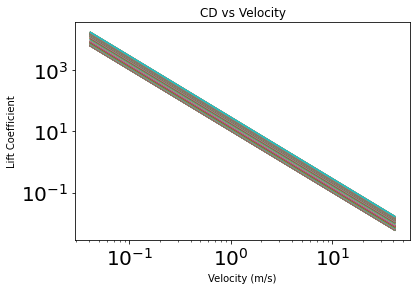

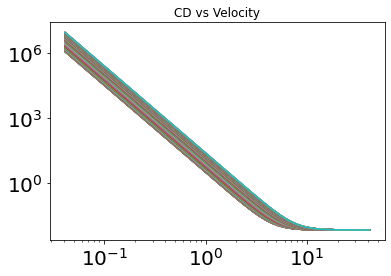

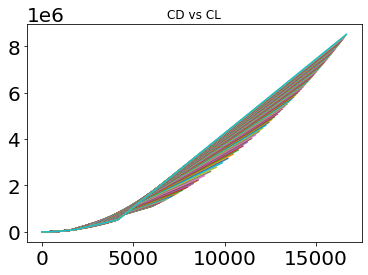

(1000,) (140, 1000)


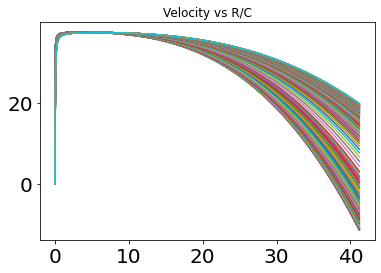

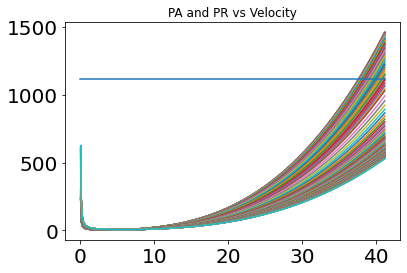

In [4]:
# INITIAL VALUES
cd0 = 0.0072
PA = 1120 # watts
PA_list = np.linspace(1120, 1120, 1000)

# Run our atomosperic calculations for all altitudes
alt_list = np.arange(1, 141, 1)
rho_list = np.empty(140)
rho_list = [atms_conditions(alt) for alt in alt_list]
rho_list = np.array(rho_list)
rho_list[0] = 0

# Calculate CL for all the values of rho
vlist = np.linspace(0, Vmax, 1000)
CL_list = [LiftCoeff(w0t, vlist, Sref, rho) for rho in rho_list]

# Calculate CD for all the values of CL
CD_list = [cd0 + CL**2/(np.pi*0.8*13.) for CL in CL_list]

CL_list = np.array(CL_list)
CD_list = np.array(CD_list)

# Calculate Thrsut Required
TR_list = [w0t/(CL_list[i,:]/CD_list[i,:]) for i in range(np.shape(CL_list)[0])]
TR_list = np.array(TR_list)

# Calculate Power Required
PR_list = [TR * vlist for TR in TR_list]
PR_list = np.array(PR_list)

# Calculate Rate of Climb
ROC_list = [(PA - PR) / w0t for PR in PR_list]
ROC_list = np.array(ROC_list)
ROC_list[:, 0] = 0 #Remove the point [0, infinity]                                        

# Calculate max ROC
ROC_MAX_list = []
for i in range(np.shape(ROC_list)[0]):
    ROC_MAX_list.append(np.max(ROC_list[i, :]))
    
# Determine which altitudes exceed our avaliable power
P_EQUAL_indexes_v = []
P_EQUAL_indexes_a = []
for i in range(np.shape(ROC_list)[0]):
    for j in range(np.shape(ROC_list)[1]):
        if (PR_list[i, j] >= PA):
            P_EQUAL_indexes_v.append(j)
            P_EQUAL_indexes_a.append(i)
            break;
            

P_EQUAL_indexes_v = np.array(P_EQUAL_indexes_v)
P_EQUAL_indexes_a = np.array(P_EQUAL_indexes_a)

print(P_EQUAL_indexes_a)

#V_EQUAL_velocities = np.sort(vlist[P_EQUAL_indexes])



########## ALL PLOTTING FROM THIS POINT ONWARDS

plt.yscale('log')
plt.xscale('log')
plt.title("Lift Coefficient vs Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Lift Coefficient")

i = 500
for CL in CL_list:
    plt.plot(vlist, CL, label="Alt={}".format(i))
    i+=500
    
plt.title("CD vs Velocity")
#plt.legend()
plt.show()

i = 500
for CD in CD_list:
    plt.plot(vlist, CD, label="Alt={}".format(i))
    i+=500
plt.yscale('log')
plt.xscale('log')
plt.title("CD vs Velocity")
#plt.legend()
plt.show()

for i in range(np.shape(CL_list)[0]):
    plt.plot(CL_list[i], CD_list[i], label="Alt={}".format(i))

plt.title("CD vs CL")
#plt.legend()
plt.show()

print(np.shape(vlist), np.shape(ROC_list))

for i in range(np.shape(ROC_list)[0]):
    plt.plot(vlist, ROC_list[i, :])
plt.title("Velocity vs R/C")
plt.show()

for i in range(np.shape(PR_list)[0]):
    plt.plot(vlist, PR_list[i], label = 'PR{}'.format(i))
plt.plot(vlist, PA_list, label = 'PA')
plt.title("PA and PR vs Velocity")
#plt.legend()
plt.show()



(140,) (140,)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140]


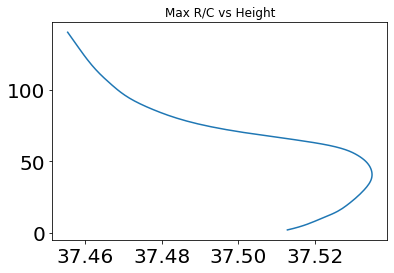

In [5]:
print(np.shape(ROC_MAX_list), np.shape(alt_list))

print(alt_list)


plt.plot(ROC_MAX_list, alt_list)
plt.title("Max R/C vs Height")
plt.show()

In [6]:
# 61-80: Condensate Haze
# 80-140: Tholin Haze
# 17-35: CH4-N2 Clouds
# Lower Surafce

CH_upper = np.linspace(80,80,140)
CH_lower = np.linspace(61,61,140)
TH_lower = np.linspace(80, 80,140)
TH_upper = np.linspace(140,140,140)
CH4_upper = np.linspace(35,35,140)
CH4_lower = np.linspace(17,17,140)

len(ROC_MAX_list)

140

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


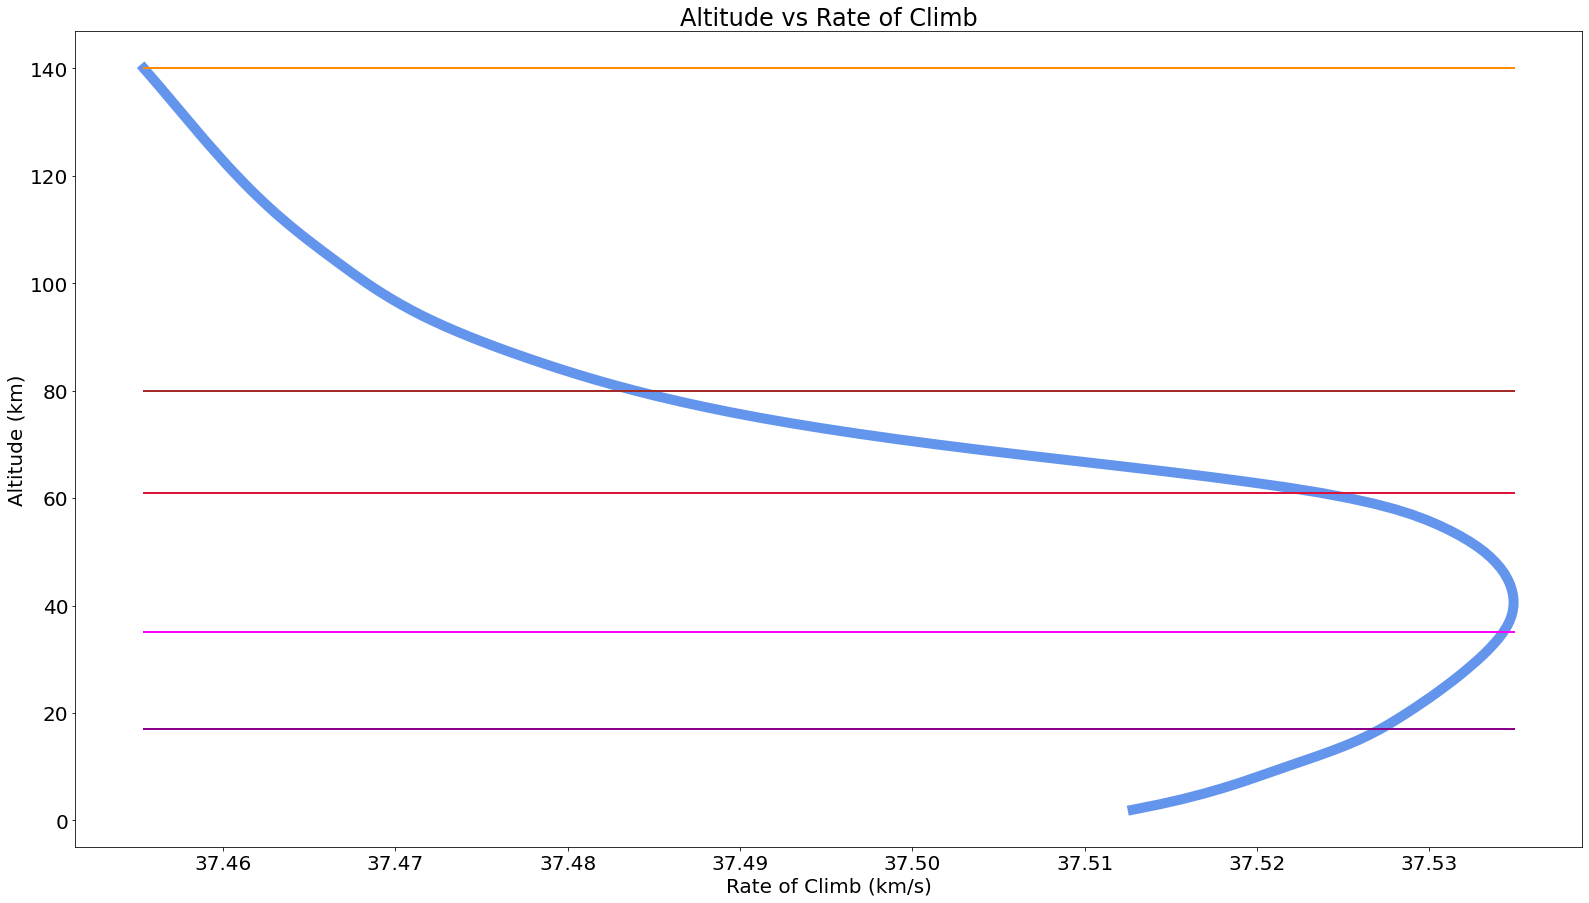

In [7]:
plt.figure(figsize=(27,15))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
plt.plot(ROC_MAX_list, alt_list, linewidth=10, color='cornflowerblue')
plt.plot(ROC_MAX_list, CH_upper, linewidth=2, color='BROWN', label = "Condensate Haze Upper Bound and Tholin Haze Lower Bound")
plt.plot(ROC_MAX_list, CH_lower, linewidth=2, color='crimson', label ="Condensate Haze Lower Bround")
plt.plot(ROC_MAX_list, TH_upper, linewidth=2, color='darkorange', label = 'Tholin Haze Upper Bound')
plt.plot(ROC_MAX_list, CH4_upper, linewidth=2, color='magenta', label = 'CH4-N2 Clouds Upper Bound')
plt.plot(ROC_MAX_list, CH4_lower, linewidth=2, color='darkmagenta', label = 'CH4-N2 Clouds Lower Bound')
#plt.plot(CH_upper)
plt.title("Altitude vs Rate of Climb")
plt.xlabel("Rate of Climb (km/s)")
plt.ylabel("Altitude (km)")
#plt.legend(bbox_to_anchor=(-0.1,0), loc="lower right",  prop={'size': 50})
plt.savefig('img')
plt.show()


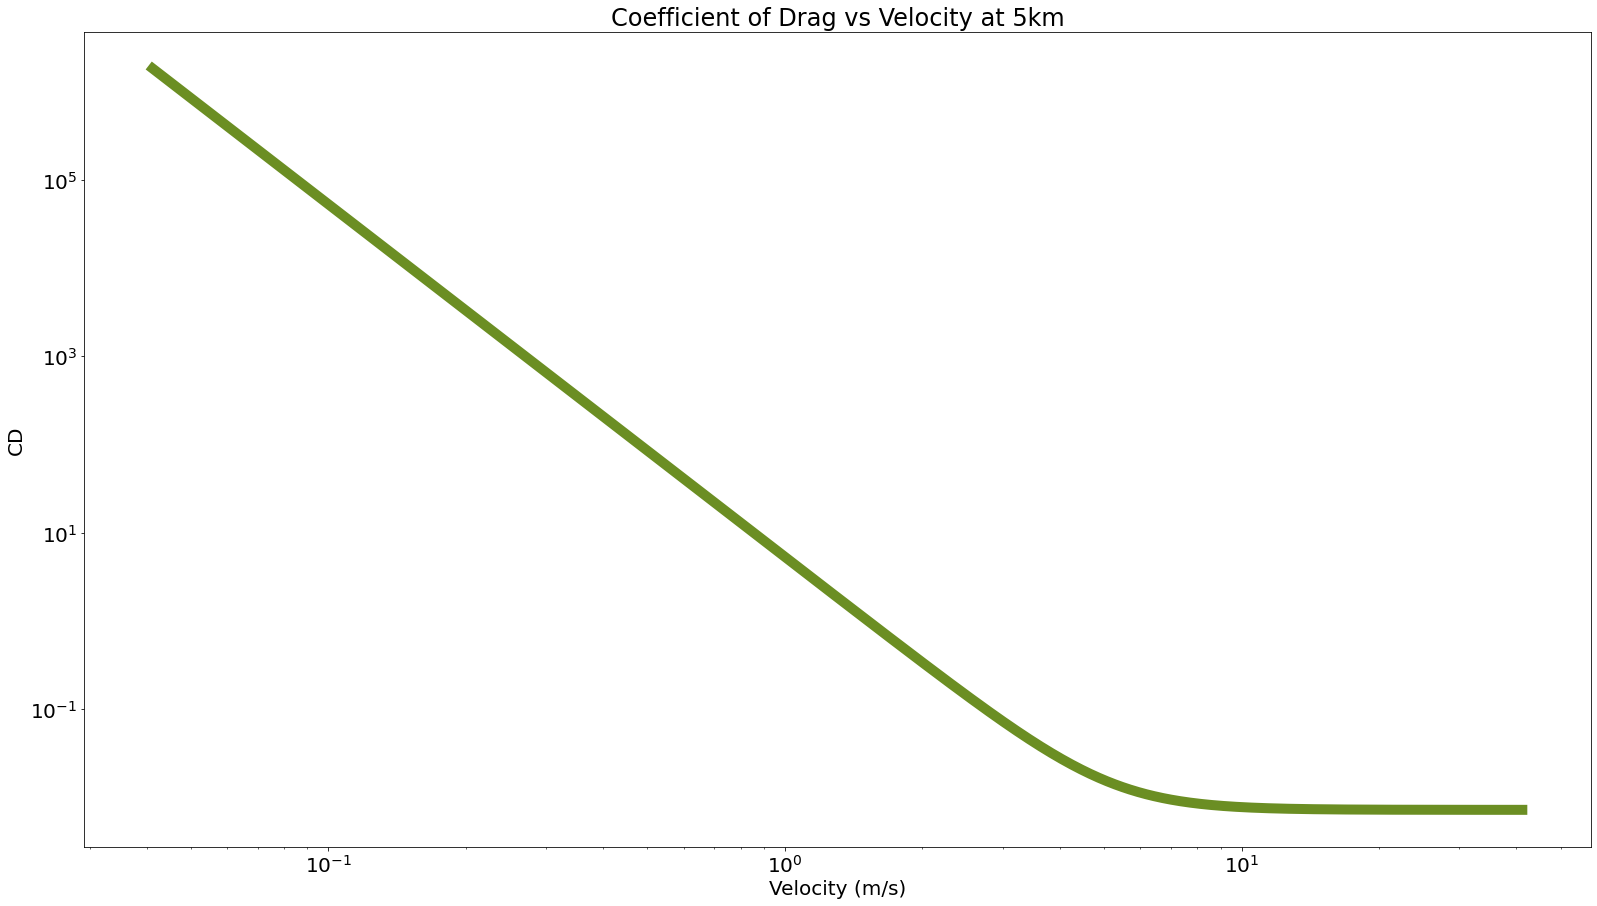

In [8]:
plt.figure(figsize=(27,15))
plt.xscale('log')
plt.yscale('log')
plt.title("Coefficient of Drag vs Velocity at 5km")
plt.xlabel("Velocity (m/s)")
plt.ylabel("CD")
plt.plot(vlist, CD_list[6], linewidth=10, color="olivedrab")
plt.savefig("CD5k")

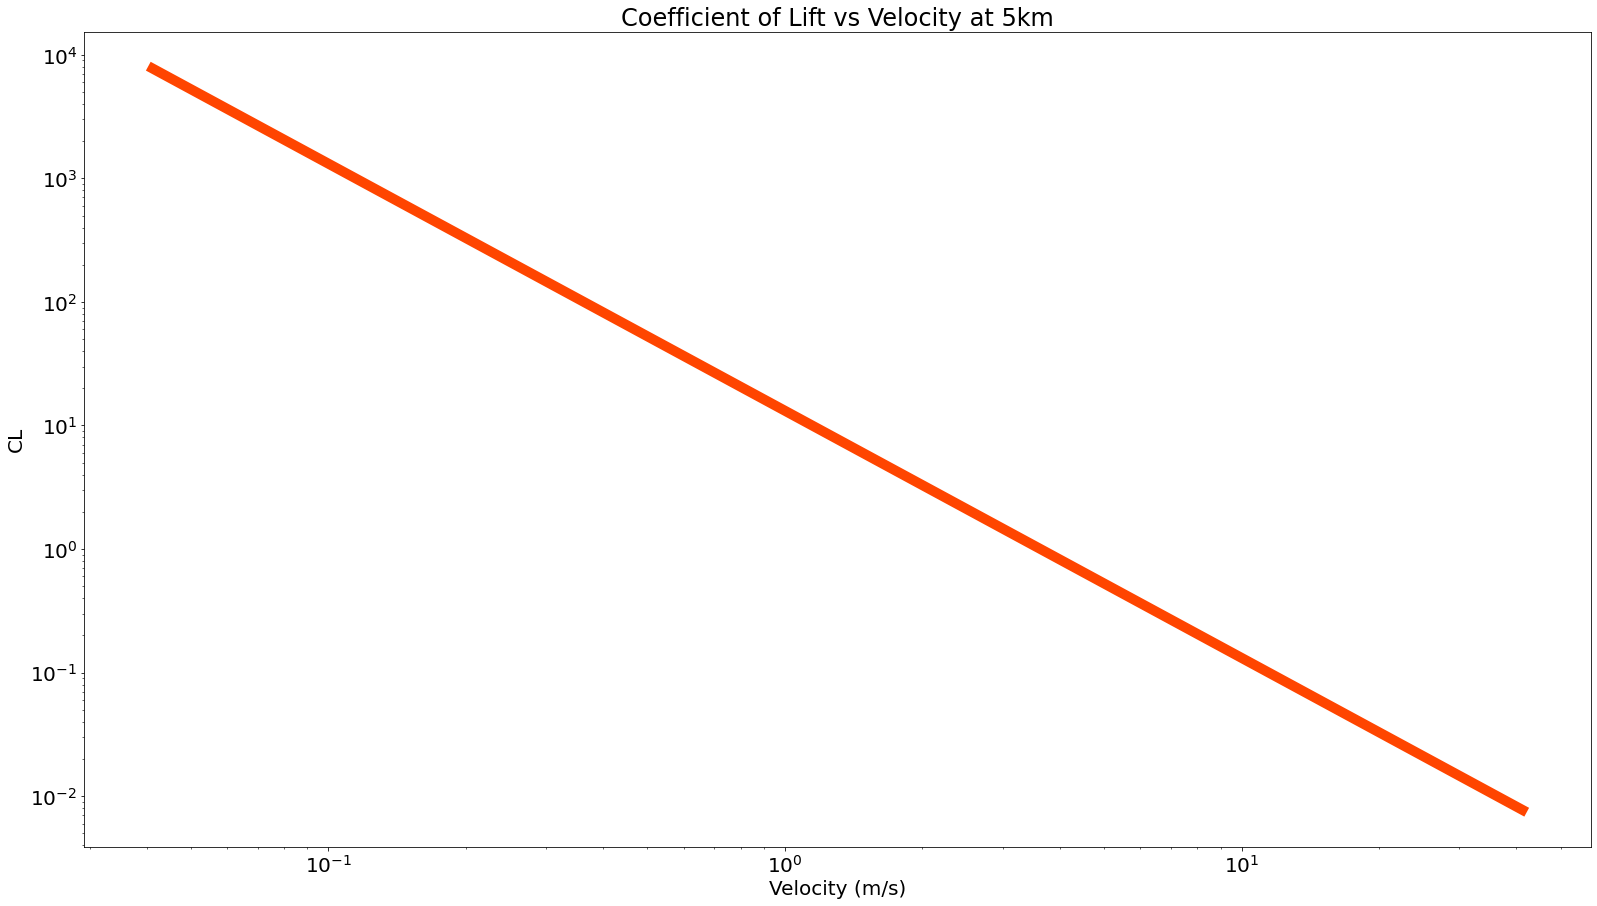

In [9]:
plt.figure(figsize=(27,15))
plt.xscale('log')
plt.yscale('log')
plt.title("Coefficient of Lift vs Velocity at 5km")
plt.xlabel("Velocity (m/s)")
plt.ylabel("CL")
plt.plot(vlist, CL_list[6], linewidth=10, color="orangered")
plt.savefig("CL5k")

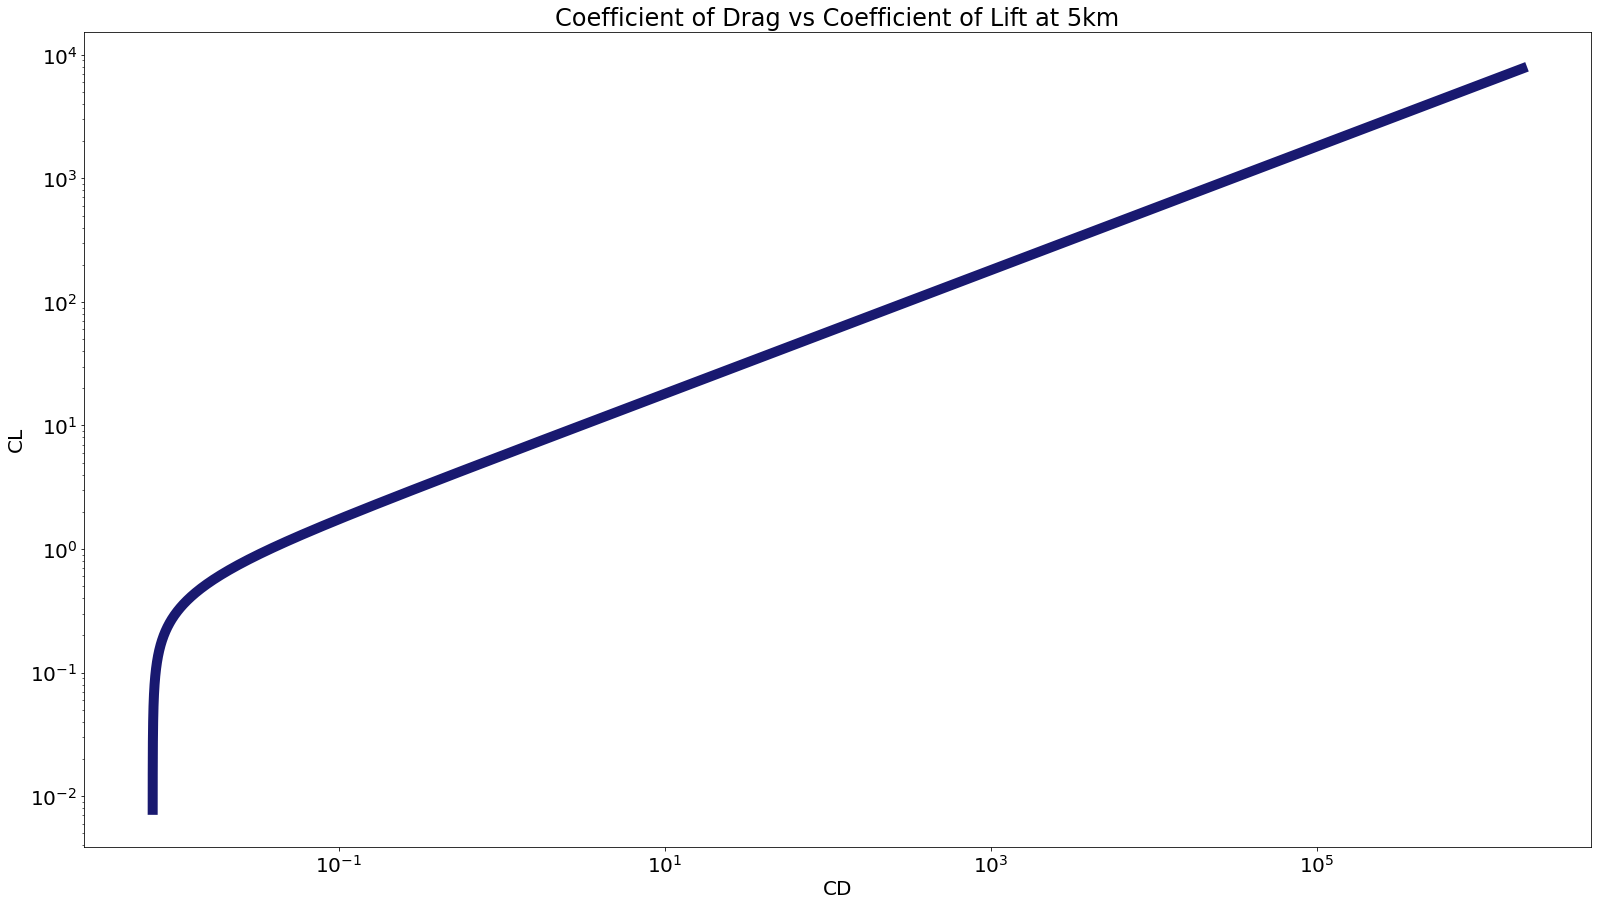

In [10]:
plt.figure(figsize=(27,15))
plt.xscale('log')
plt.yscale('log')
plt.title("Coefficient of Drag vs Coefficient of Lift at 5km")
plt.xlabel("CD")
plt.ylabel("CL")
plt.plot(CD_list[6], CL_list[6], linewidth=10, color="midnightblue")
plt.savefig("CDCL")

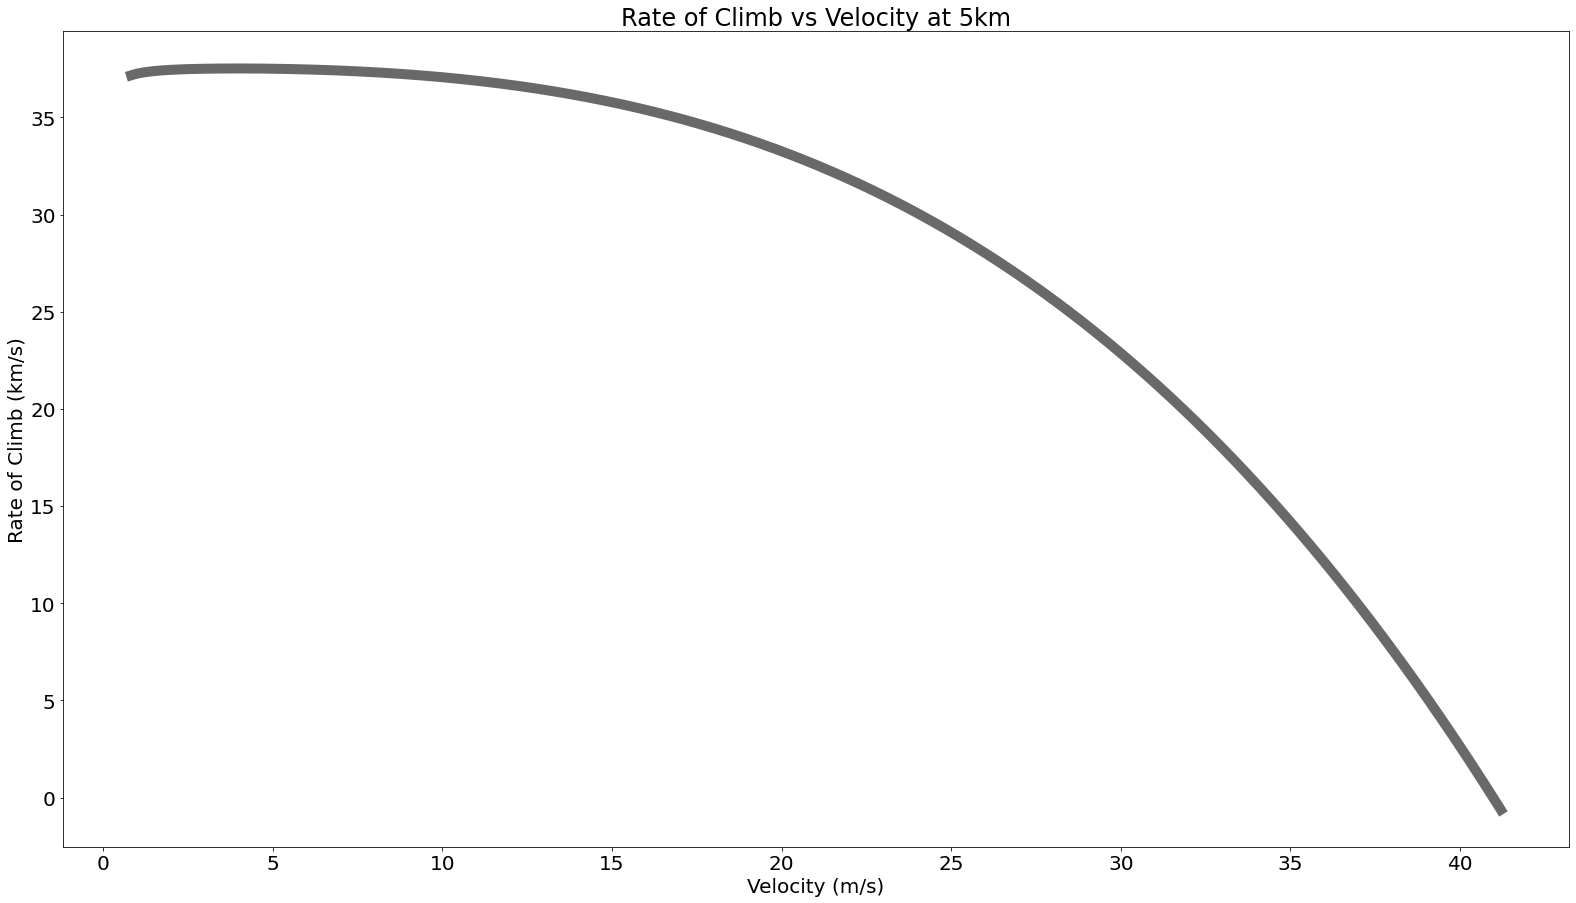

In [11]:
plt.figure(figsize=(27,15))
plt.title("Rate of Climb vs Velocity at 5km")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Rate of Climb (km/s)")
plt.plot(vlist[20:], ROC_list[6, 20:], linewidth=10, color="dimgrey")
plt.savefig("CDv")

Point of Intersection at 41.2 m/s


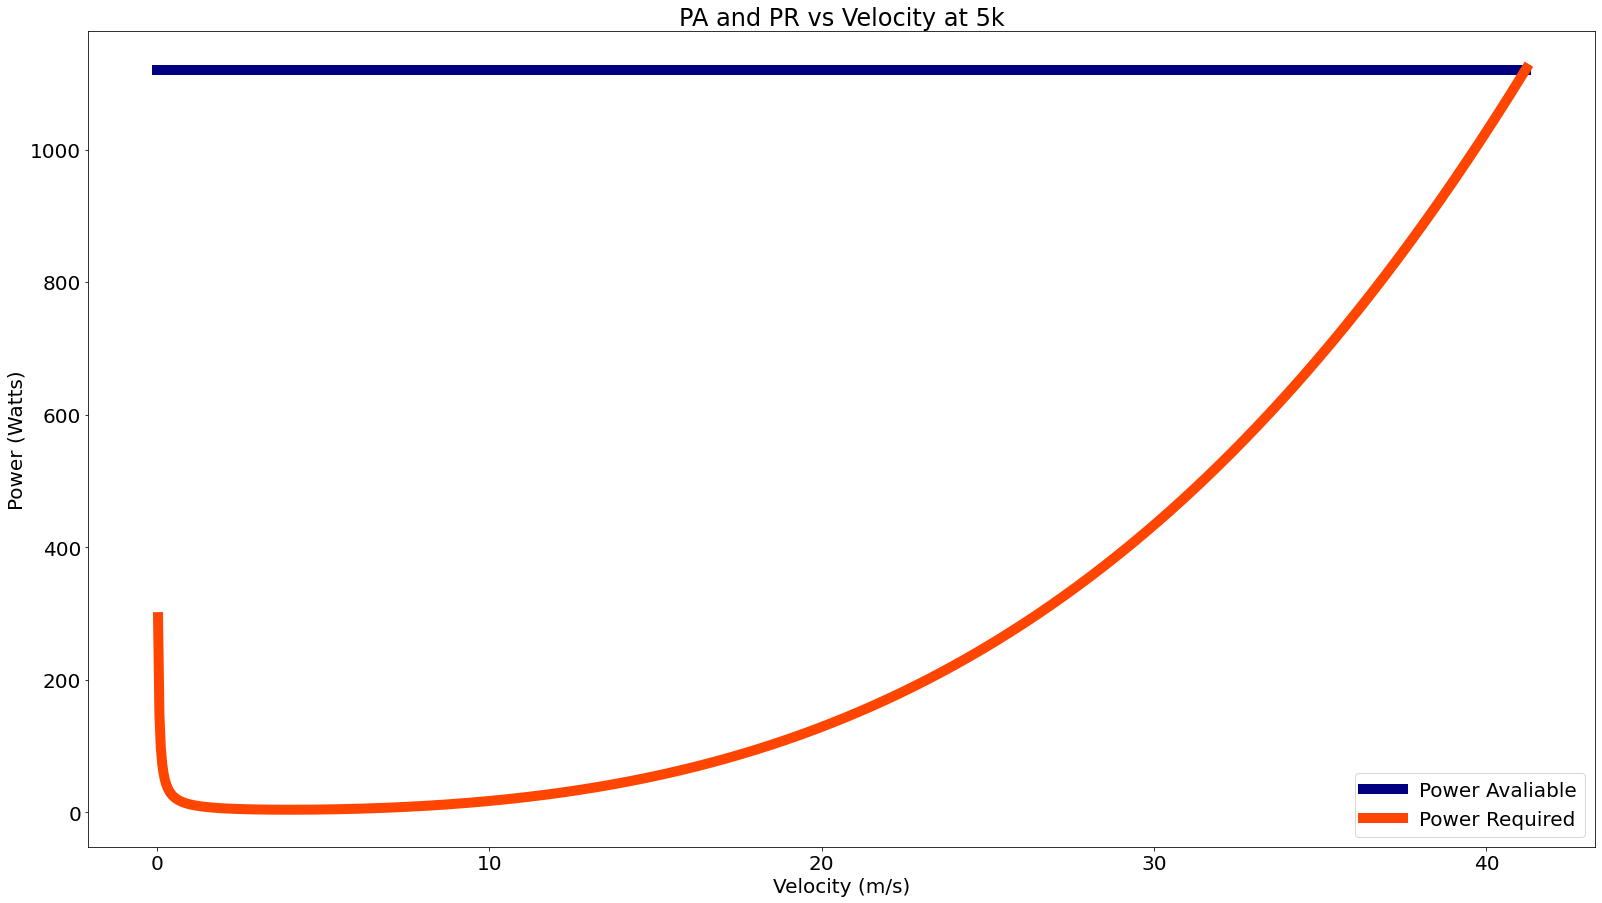

In [25]:
for i in range(len(PR_list[5])):
    if(PR_list[5,i]>=PA):
        index=i
        break;

VequalPR=vlist[index]

plt.figure(figsize=(27,15))
plt.title("PA and PR vs Velocity at 5k")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Power (Watts)")
plt.plot(vlist, PA_list, linewidth=10, color='navy', label='Power Avaliable')
plt.plot(vlist, PR_list[5], linewidth=10, color='orangered', label='Power Required')
plt.legend()
plt.savefig("PAPR")

print("Point of Intersection at {} m/s".format(VequalPR))


In [17]:
#rate of climb calc
def roc(rho,v):
    cl = w0t/(.5*rho*(v**2)*Sref)
    cd = 0.0072 + ((cl**2)/(math.pi*0.8*13))
    Tr = w0t/(cl/cd)
    Pr = Tr*v
    rc = (1120 - Pr)/w0t
    return rc

print(roc(atms_conditions(5),25))
    
29.341666165952088


29.341666165952088


In [12]:
#liftoff calculations using equation to solve thrust
def Tlo(Slo,muR,rho):
    cl = 1.627948514
    v = 0.7*1.2*math.sqrt((2*w0t)/(rho*Sref*cl))
    cd = 0.011 + ((cl**2)/(math.pi*0.8*13))
    D = 0.5*rho*(v**2)*Sref*cd
    L = 0.5*rho*(v**2)*Sref*cl
    Tlo = ((1.44*w0t**2)/(Slo*gt*rho*Sref*cl)) + (D + muR*(w0t-L))
    return Tlo,v,D,L

def PRtr(tr,rho):
    cl = 1.627948514
    v = 0.7*1.2*math.sqrt((2*w0t)/(rho*Sref*cl))
    Pr = tr*v
    return Pr

print(Tlo(30,0.09,atms_conditions(0.00000000000000000000000000000000001)))
print(PRtr(Tlo(30,0.09,atms_conditions(0.00000000000000000000000000000000001))[0],atms_conditions(0.00000000000000000000000000000000001)))

#angle of attack of 7 deg


(6.891703826246838, 2.563135768522939, 1.1875309759408195, 20.9873664)
17.66437258311967


In [13]:
#landing at max weight
def Sland(muR,rho):
    cl = 1.627948514
    v = 1.3*math.sqrt((2*w0t)/(rho*Sref*cl))
    cd = 0.011 + ((cl**2)/(math.pi*0.8*13))
    D = 0.5*rho*(v**2)*Sref*cd
    L = 0.5*rho*(v**2)*Sref*cl
    Sland = ((1.69*w0t**2)/(gt*rho*cl*((D+muR*(w0t-L)))))
    return Sland,v, D, L 

print(Sland(0.09,atms_conditions(0.00000000000000000000000000000000001)))


(129.1418086813861, 3.966757736999787, 2.844284792148505, 50.26736000000001)


In [14]:
#takeoff length if using max power
def Slo(muR,rho):
    cl = 1.627948514
    v = 1.3*math.sqrt((2*w0t)/(rho*Sref*cl))
    cd = 0.011 + ((cl**2)/(math.pi*0.8*13))
    D = 0.5*rho*(v**2)*Sref*cd
    L = 0.5*rho*(v**2)*Sref*cl
    T = 1120/v
    Sland = ((1.44*w0t**2)/(gt*rho*cl*(T-(D+muR*(w0t-L)))))
    return Sland,v, D, L 

def PRtr(tr,rho):
    cl = 1.627948514
    v = 1.3*math.sqrt((2*w0t)/(rho*Sref*cl))
    Pr = tr*v
    return Pr

print(Slo(0.09,atms_conditions(0.00000000000000000000000000000000001)))

(0.3900061458097727, 3.966757736999787, 2.844284792148505, 50.26736000000001)


In [27]:
#takeoff at min weight
def Tlo(Slo,muR,rho):
    w = (22-1.5)*1.352
    cl = 1.627948514
    v = 0.7*1.2*math.sqrt((2*w)/(rho*Sref*cl))
    cd = 0.011 + ((cl**2)/(math.pi*0.8*13))
    D = 0.5*rho*(v**2)*Sref*cd
    L = 0.5*rho*(v**2)*Sref*cl
    Tlo = ((1.44*w**2)/(Slo*gt*rho*Sref*cl)) + (D + muR*(w-L))
    return Tlo,v,D,L

def PRtr(tr,rho):
    w = (22-1.5)*1.352
    cl = 1.627948514
    v = 0.7*1.2*math.sqrt((2*w)/(rho*Sref*cl))
    Pr = tr*v
    return Pr

print(Tlo(30,0.09,atms_conditions(0.00000000000000000000000000000000001)))
print(PRtr(Tlo(30,0.09,atms_conditions(0.00000000000000000000000000000000001))[0],atms_conditions(0.00000000000000000000000000000000001)))

#angle of attack of 7 deg
2.474213666102042 1.1065629548539453, 19.5564096) 6.109481599128953
15.116162865363815

(6.109481599128953, 2.474213666102042, 1.1065629548539453, 19.5564096)
15.116162865363815


In [28]:
#landing at min weight
def Sland(muR,rho):
    w = (22-1.5)*1.352
    cl = 1.627948514
    v = 1.3*math.sqrt((2*w)/(rho*Sref*cl))
    cd = 0.011 + ((cl**2)/(math.pi*0.8*13))
    D = 0.5*rho*(v**2)*Sref*cd
    L = 0.5*rho*(v**2)*Sref*cl
    Sland = ((1.69*w**2)/(gt*rho*cl*((D+muR*(w-L)))))
    return Sland,v, D, L 

print(Sland(0.09,atms_conditions(0.00000000000000000000000000000000001)))

(120.33668536220064, 3.829140197538875, 2.6503562835929246, 46.84004)


In [13]:
#maneuver w/ max weight
def n(rho,w):
    cl = 1.627948514
    v = 1.2*math.sqrt((2*w)/(rho*Sref*cl))
    n = (0.5*rho*(v**2)*Sref*cl)/(w)
    return n

def R(n,rho,w):
    cl = 1.627948514
    v = 1.2*math.sqrt((2*w)/(rho*Sref*cl))
    R = (v**2)/(gt*(n-1))
    return R


print(n(atms_conditions(0.00000000000000000000000000000000001),29.744))
print(R(n(atms_conditions(0.00000000000000000000000000000000001),29.744),atms_conditions(0.00000000000000000000000000000000001),29.744))

print(math.sqrt((R(n(atms_conditions(0.00000000000000000000000000000000001),29.744),atms_conditions(0.00000000000000000000000000000000001),29.744)**2)-((R(n(atms_conditions(0.00000000000000000000000000000000001),29.744),atms_conditions(0.00000000000000000000000000000000001),29.744)-30)**2))) 

1.44
22.538124539888948
21.2670513328326

1.44
22.538124539888948
21.2670513328326


In [14]:
#maneuver at min weight
def n(rho,w):
    cl = 1.627948514
    v = 1.2*math.sqrt((2*w)/(rho*Sref*cl))
    n = (0.5*rho*(v**2)*Sref*cl)/(w)
    return n

def R(n,rho,w):
    cl = 1.627948514
    v = 1.2*math.sqrt((2*w)/(rho*Sref*cl))
    R = (v**2)/(gt*(n-1))
    return R


print(n(atms_conditions(0.00000000000000000000000000000000001),27.716))
print(R(n(atms_conditions(0.00000000000000000000000000000000001),27.716),atms_conditions(0.00000000000000000000000000000000001),27.716))

print(math.sqrt((R(n(atms_conditions(0.00000000000000000000000000000000001),27.716),atms_conditions(0.00000000000000000000000000000000001),27.716)**2)-((R(n(atms_conditions(0.00000000000000000000000000000000001),27.716),atms_conditions(0.00000000000000000000000000000000001),27.716)-30)**2))) 


1.4399999999999997
21.001434230351073
18.975933542807965


In [ ]:
1.4399999999999997
21.001434230351073
18.975933542807965